In [1]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import helperfuns
from helperfuns import *
from numpy.lib.scimath import sqrt as csqrt
import matplotlib as mpl
import matplotlib.pyplot as plt
from helperfuns import *
from equilibriumfuns import *
fig_directory = '/Users/taliaborofsky/Documents/\
PhD Research/PopDynamics_SocLearning/PopDynamics_TeX/Figures_NoDelay'
green, yellow, purple, red, blue, orange = '#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462'
from matplotlib.collections import LineCollection

from equilibria_analysis_funs import *
import multiprocessing as mp
from itertools import repeat

In [2]:
run_generate_smaxvecs = False

In [38]:
Rvals = np.array([0.1, 0.1, 0.4, 0.2])
δvals = np.array([0.15, 0.2, 0.5, 0.5])
muvals = np.linspace(-1,1,2000)
if run_generate_smaxvecs:
    muvals = np.linspace(-1,1,2000)

    μmat, whichRδ = np.meshgrid(muvals, [0,1,2,3])
    μ, whichRδ = [np.ndarray.flatten(item) for item in [μmat, whichRδ]]
    Rvals = np.array([0.1, 0.1, 0.4, 0.2])
    δvals = np.array([0.15, 0.2, 0.5, 0.5])
    R = Rvals[whichRδ]
    δ = δvals[whichRδ]
    list_param_vecs = np.array([μ, R, δ]).T


    print("Number of processors: ", mp.cpu_count())
    # Step 1: Init multiprocessing.Pool()


    pool = mp.Pool(mp.cpu_count())
    out = pool.map(custmax_s_2,list_param_vecs)

    pool.close()
    outmat = np.vstack(out)

    s0, s1, Nβ0, Nβ1 = outmat.T
    μ, R, δ = list_param_vecs.T
    df = pd.DataFrame({'s0':s0, 's1':s1, 'Nβ0':Nβ0, 'Nβ1':Nβ1,
                      'mu':μ, 'R':R, 'delta':δ })
    df.to_csv('lines_sstar.csv')
else:
    df = pd.read_csv('lines_sstar.csv')
df = df.drop(labels = 'Unnamed: 0', axis = 1)

In [41]:
df.columns

Index(['s0', 's1', 'Nβ0', 'Nβ1', 'mu', 'R', 'delta'], dtype='object')

In [39]:
df.values.T

array([[ 0.20824165,  0.21004201,  0.21244249, ...,  0.90018004,
         0.90018004,  0.89957992],
       [ 1.57977811,  1.5784627 ,  1.57689911, ...,  0.90118004,
         0.90118004,  0.90057992],
       [ 4.05      ,  4.04999993,  4.04999983, ...,  0.53333333,
         0.53333333,  0.53333333],
       ...,
       [-1.        , -0.9989995 , -0.997999  , ...,  0.997999  ,
         0.9989995 ,  1.        ],
       [ 0.1       ,  0.1       ,  0.1       , ...,  0.2       ,
         0.2       ,  0.2       ],
       [ 0.15      ,  0.15      ,  0.15      , ...,  0.5       ,
         0.5       ,  0.5       ]])

In [42]:
Rδ_combos

array([[0.1 , 0.15],
       [0.1 , 0.2 ],
       [0.4 , 0.5 ],
       [0.2 , 0.5 ]])

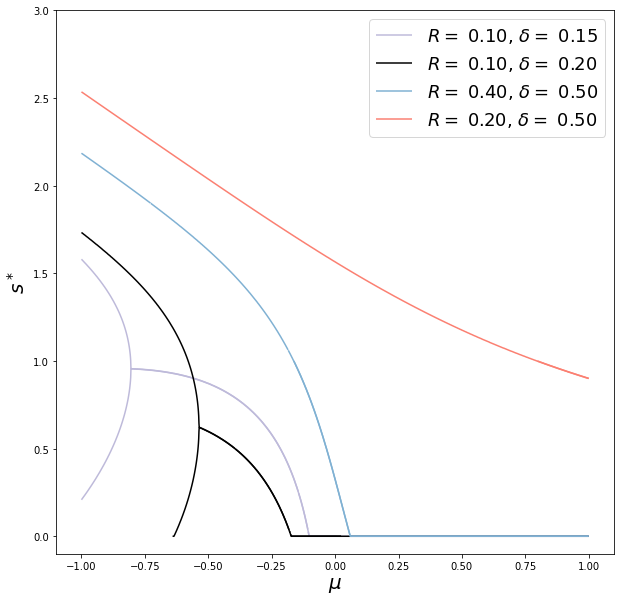

In [50]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

Rδ_combos = np.stack([Rvals,δvals]).T
#lines = []
colors = [purple, 'k', blue, red]
for i,Rδ in enumerate(Rδ_combos):
    R, δ = Rδ
    df_use = df.loc[(df.R==R) & (df.delta == δ),:]
    datamat = df_use.values.T
    s0,s1,Nβ0, Nβ1,_,_,_ = datamat
    lab = r'$R = $ %.2f, $\delta = $ %.2f'%(R,δ)
    line = LineCollection([list(zip(muvals,y)) for y in [s0, s1]], 
                        color = colors[i], label = lab)
    
    ax.add_collection(line)
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-0.1,3])

ax.set_xlabel(r'$\mu$', fontsize = 20)
ax.set_ylabel(r'$s^*$', fontsize = 20)

ax.legend(fontsize=18)
fig.savefig(fig_directory + '/Optimals_RlessthanDelta.jpg',dpi=600)

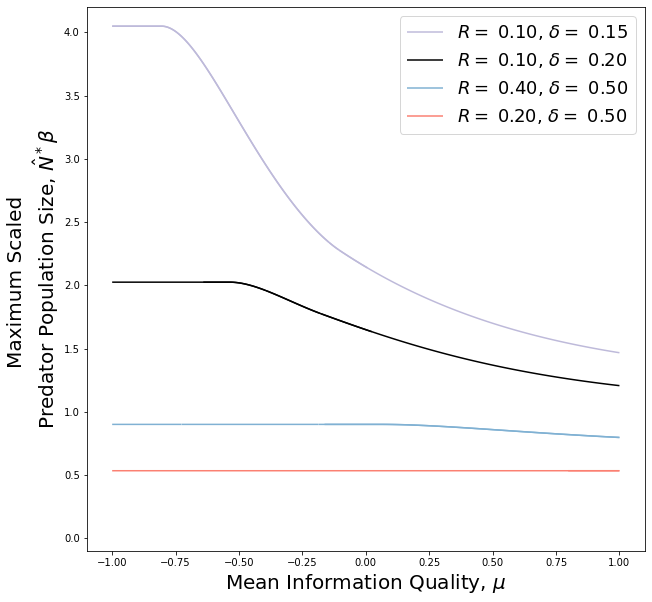

In [78]:
labelformat = dict(fontsize = 20)
titleformat = dict(fontsize = 20)
legendfont = dict(fontsize = 18)

fig,ax = plt.subplots(1,1,figsize=(10,10))

Rδ_combos = np.stack([Rvals,δvals]).T
#lines = []
colors = [purple, 'k', blue, red]
for i,Rδ in enumerate(Rδ_combos):
    R, δ = Rδ
    df_use = df.loc[(df.R==R) & (df.delta == δ),:]
    datamat = df_use.values.T
    s0,s1,Nβ0, Nβ1,_,_,_ = datamat
    lab = r'$R = $ %.2f, $\delta = $ %.2f'%(R,δ)
    line = LineCollection([list(zip(muvals,y)) for y in [Nβ0, Nβ1]], 
                        color = colors[i], label = lab)
    
    ax.add_collection(line)
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-0.1,4.2])

ax.set_xlabel(r'Mean Information Quality, $\mu$', **labelformat)
ax.set_ylabel('Maximum Scaled \nPredator Population Size, '+r'$\beta \hat{N}^*$', **labelformat)

ax.legend(**legendfont)
#fig.savefig(fig_directory + '/OptimalN_RlessthanDelta.jpg',dpi=600)



In [95]:
def fig_sizes_vs_s(R, δ, mu):
    
    fig,ax = plt.subplots(1,1,figsize=(8,6))


    svec = np.linspace(0,3,1000)
    Kvec = Kfun(svec, scs.norm(mu))
    pcvec = pcfun(svec, scs.norm(mu))
    rvec = get_r_hat_vec1(Kvec, pcvec, δ, R)
    uvec = u_r_hat(rvec,R,δ)
    plt.plot(Kvec,get_Nβ_r(rvec, δ, R), color = 'k', label = r'$β\hat{N}$')
    plt.plot(Kvec, rvec, color = red, label = r'$\hat{r}$')
    plt.plot (Kvec, uvec, color = blue, label = r'$\hat{u}_r$')

    plt.xlabel('Social Learning Probability, K', **labelformat)
    plt.ylabel('Size', **labelformat)
    #plt.ylabel(r'$\hat{N}β$ or $\hat{r}$ or $\hat{u}_r$', **labelformat)
    plt.legend(**legendfont)
    t = r'$\mu = $%.2f, $R = $ %.2f, $\delta = $ %.2f'%(mu,R,δ)
    plt.title(t, **titleformat)
    
    return(fig)

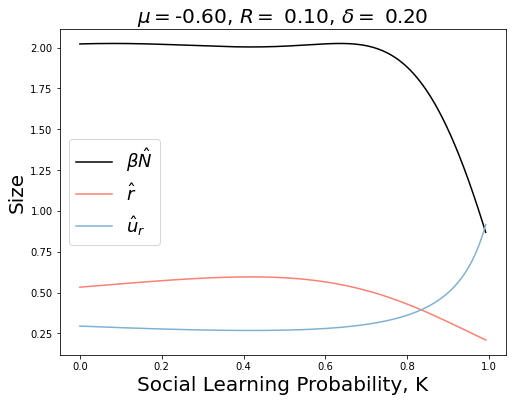

In [113]:
fig1 = fig_sizes_vs_s(R = 0.1, δ = 0.2, mu = -0.6)

Increasing social learning makes little difference until around K = 0.8. Then an increase in $\hat{u}_r$ seems to cause a decline in CP density $\hat{r}$ and subsequently a decline in predator population size $\hat{N}$.

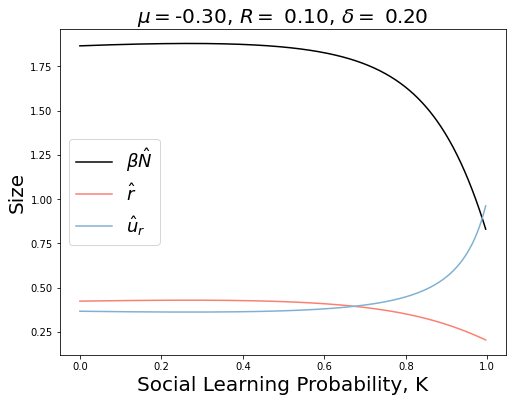

In [114]:
#fig.savefig(fig_directory + '/Sizes_vs_K_muRdelta1.jpg',dpi=600)
fig2 = fig_sizes_vs_s(R = 0.1, δ = 0.2, mu = -0.3)

Like above, increasing social learning makes little difference until around K = 0.8. Then an increase in $\hat{u}_r$ seems to cause a decline in CP density $\hat{r}$ and subsequently a decline in predator population size $\hat{N}$.

It's interesting how the $s*$ plot makes these look like very different situations, but here they do not look so different. Next we should find stability

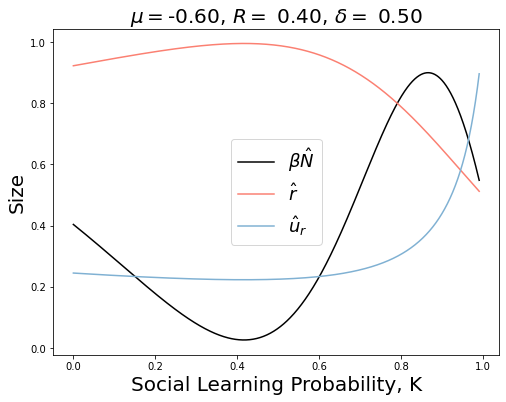

In [116]:
fig3 = fig_sizes_vs_s(R = 0.4, δ = 0.5, mu = -0.6)

Now there's a super nonlinear relationship between social learning and predator population size. Intermediate values of social learning are bad for the predators, WHY?

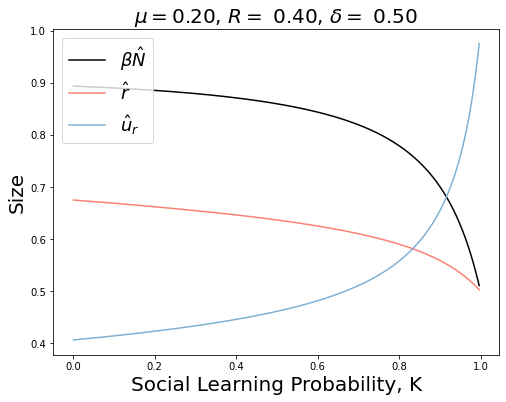

In [117]:
fig4 = fig_sizes_vs_s(R = 0.4, δ = 0.5, mu = 0.2)

The CP behavior takes over the population as K increases to 1. Social learning seems to lock the population into harvesting the CP even as the CP population size shrinks.

Text(0.5, 1.0, '$\\mu = $0.25, $R = $ 0.40, $\\delta = $ 0.50')

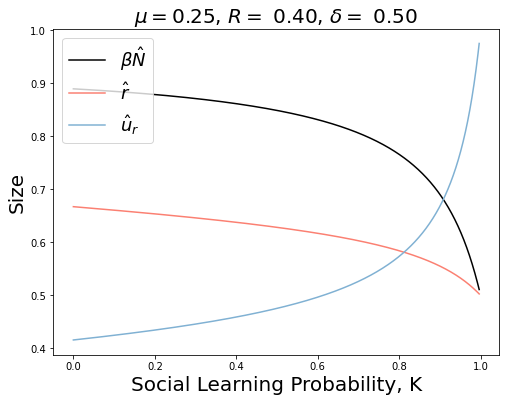